In [1]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.


In [2]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learner import Learner
from learn_KKL.raffinement import *
#sb.set_style('whitegrid')

In [3]:
# Set up the system
system = RevDuffing()

In [30]:
# Instantiate the observer
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised', wc=0.03,
                              activation=torch.nn.SiLU())
observer.set_dynamics(system)
# Generate (x_i, z_i) data by running system backward, then system + observer
# forward in time
data = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [20,20],
                                  method='adaptative')
data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

In [ ]:
# Train the forward transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data,
                    validation_data=val_data, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


torch.Size([400, 5])


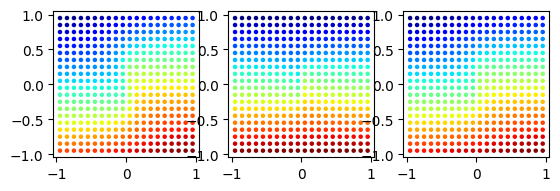

In [31]:
print(data.shape)
im,ax = plt.subplots(1,3)
for i in range(3):
    ax[i].scatter(data[:,0],data[:,1],c = data[:,2+i],s=5,cmap='jet')
    ax[i].axis('square')
plt.show()

Computed the smallest possible uniform grid for the given dimensions, then deleted 24 samples randomly to match the desired number of samples 300.


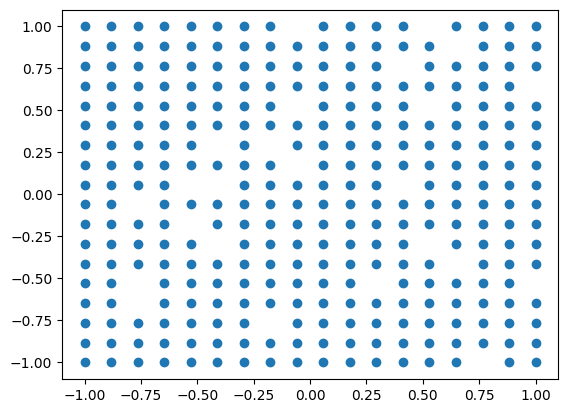

In [29]:
from learn_KKL.utils import generate_mesh
data = generate_mesh(np.array([[-1, 1.], [-1., 1.]]), [20,15],
                                  method='uniform')
plt.scatter(data[:,0],data[:,1])
plt.show()

In [10]:
def f(x,method):
    match method:
        case "a":
            return x
        case "b":
            return x**2
        case "c":
            return x**3

f(2,"c")



8

In [ ]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T)
learner_T.save_results(limits=np.array([[-1, 1.], [-1., 1.], [-1., 1.]]),
                       nb_trajs=10, tsim=(0, 60), dt=1e-2,
                       checkpoint_path=checkpoint_callback.best_model_path)

In [ ]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 20}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data,
                         validation_data=val_data, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


In [ ]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T_star.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T_star)
learner_T_star.save_results(limits=np.array([[-1, 1.], [-1., 1.]]),
                            nb_trajs=10, tsim=(0, 60), dt=1e-2,
                            checkpoint_path=checkpoint_callback.best_model_path)

In [ ]:
x_mesh = data[:, 0:2]
z_mesh = data[:, 2:5]
z_hat = learner_T.model("T", x_mesh)
x_hat = learner_T_star.model("T_star",z_mesh)
erreur_z = z_hat - z_mesh
erreur_x = x_hat - x_mesh
im,ax = plt.subplots(1,3)
for i in range(3):
    ax[i].scatter(data[:,0],data[:,1],c = erreur_z[:,i],s=5,cmap='jet')
    ax[i].axis('square')
plt.show()

In [ ]:
im,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(x_mesh[:,0],x_mesh[:,1])
ax1.axis('square')
ax2.scatter(x_hat[:,0].detach(),x_hat[:,1].detach())